<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-filip-martin/blob/main/noise_recognition/Noise_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Základní klasifikace - malý dataset, 128x128
Slouží k nastavení základního fungování

## Validace dat
Ověření, že data z hlediska formátu obsahují vše co mají a po vizuální stránkce vypadají "normálně"

### Zobrazení formátu dat
- slouží k ověření, že data jsou ve správném formátu a obsahují labely

In [ ]:
import h5py

# Path to your HDF5 file
file_path = "./data/chunk_0.h5"

# Function to list datasets and attributes
def inspect_hdf5_file(file_path):
    """List all datasets and attributes in an HDF5 file."""
    with h5py.File(file_path, "r") as hf:
        print("\n--- HDF5 File Structure ---")
        def print_hierarchy(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name} | Shape: {obj.shape} | Dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")

        # Print all groups and datasets
        hf.visititems(print_hierarchy)

        # Print attributes
        print("\n--- File Attributes ---")
        for attr in hf.attrs:
            print(f"{attr}: {hf.attrs[attr]}")

# Inspect the file
inspect_hdf5_file(file_path)


--- HDF5 File Structure ---
Dataset: labels | Shape: (2556,) | Dtype: int32
Dataset: spectrograms | Shape: (2556, 128, 128) | Dtype: float32

--- File Attributes ---
class_mapping: {'engine': 0, 'speech': 1, 'music': 2}


### Validace hodnot
- Vizuální kontrola, že hodnoty v datasetu se pohybují v rozumných mezích.

In [ ]:
import numpy as np
import h5py

def calculate_statistics_from_h5_file(h5_file_path):
    """
    Calculate overall statistics (min, max, median, average) for all spectrograms in an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.

    Returns:
        dict: Overall statistics including min, max, median, and average.
    """
    overall_min = float('inf')
    overall_max = float('-inf')
    all_medians = []
    total_sum = 0.0
    total_count = 0

    print(f"Processing: {h5_file_path}")
    try:
        with h5py.File(h5_file_path, "r") as hf:
            # Load spectrogram data
            spectrograms = hf["spectrograms"][:]  # Load all spectrograms at once

            # Update statistics
            overall_min = np.min(spectrograms)
            overall_max = np.max(spectrograms)
            all_medians.append(np.median(spectrograms))
            total_sum = np.sum(spectrograms)
            total_count = spectrograms.size

    except Exception as e:
        print(f"Error processing {h5_file_path}: {e}")
        return None

    # Compute overall statistics
    overall_average = total_sum / total_count
    overall_median = np.median(all_medians)

    # Combine results into a dictionary
    statistics = {
        "Overall Min": overall_min,
        "Overall Max": overall_max,
        "Overall Median": overall_median,
        "Overall Average": overall_average,
    }

    return statistics


if __name__ == "__main__":
    # Path to the HDF5 file
    h5_file_path = "./data/chunk_0.h5"  # Replace with your HDF5 file path

    # Calculate overall statistics
    stats = calculate_statistics_from_h5_file(h5_file_path)

    # Print the results
    if stats:
        print("\n--- Overall Statistics for Spectrograms in HDF5 File ---")
        for key, value in stats.items():
            print(f"{key}: {value}")


Processing: ./data/chunk_0.h5

--- Overall Statistics for Spectrograms in HDF5 File ---
Overall Min: -0.1147308424115181
Overall Max: 1.0932166576385498
Overall Median: 0.0029909610748291016
Overall Average: 0.07045575113550225


### Zobrazení spectogramů
- slouží pro vizuální kontrolu, že spectogramy vypadají rozumně

Total spectrograms in file: 2556


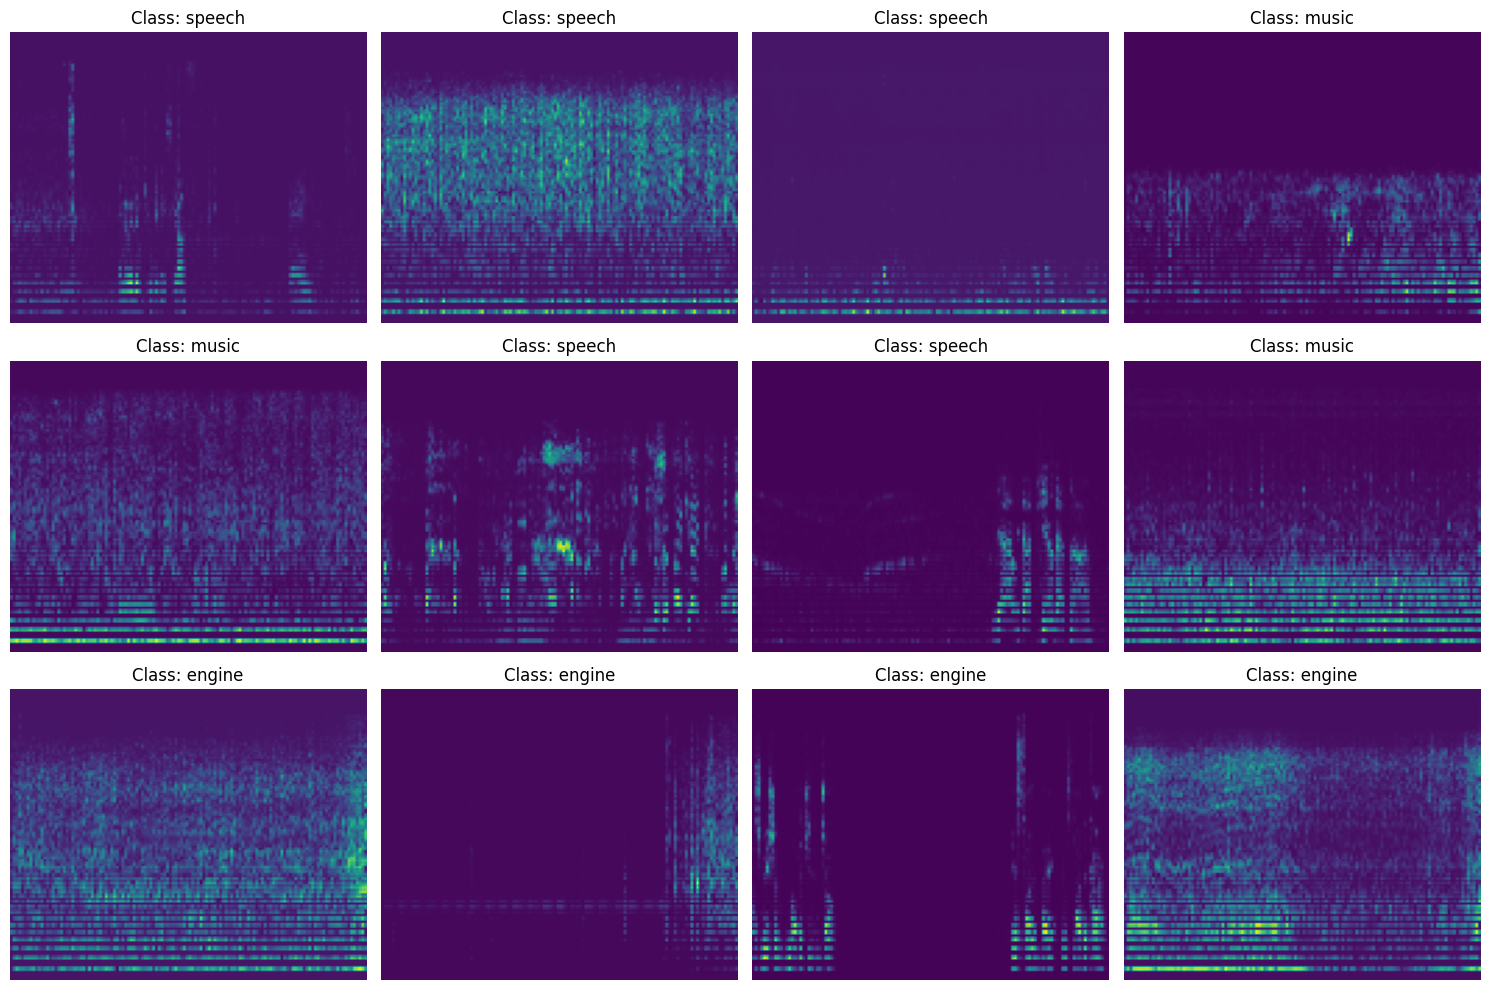

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random

def load_random_spectrograms(h5_file_path, num_samples=12):
    """
    Load a specified number of random spectrograms from an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.
        num_samples (int): Number of random spectrograms to load.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Random spectrograms and their corresponding labels.
    """
    with h5py.File(h5_file_path, "r") as hf:
        spectrograms = hf["spectrograms"][:]
        labels = hf["labels"][:]
        print(f"Total spectrograms in file: {spectrograms.shape[0]}")

        # Ensure we don't exceed the number of available samples
        num_samples = min(num_samples, spectrograms.shape[0])

        # Randomly select indices
        indices = random.sample(range(spectrograms.shape[0]), num_samples)
        random_spectrograms = spectrograms[indices]
        random_labels = labels[indices]

    return random_spectrograms, random_labels

def plot_spectrograms(spectrograms, labels, grid_shape=(3, 4), class_mapping=None):
    """
    Plot spectrograms in a grid.

    Parameters:
        spectrograms (np.ndarray): Spectrogram data to plot.
        labels (np.ndarray): Corresponding labels.
        grid_shape (tuple): Shape of the grid (rows, cols).
        class_mapping (dict): Mapping of class indices to class names (optional).
    """
    rows, cols = grid_shape
    plt.figure(figsize=(15, 10))

    for i, (spec, label) in enumerate(zip(spectrograms, labels)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(spec, aspect="auto", origin="lower", cmap="viridis")
        title = f"Class: {label}" if class_mapping is None else f"Class: {class_mapping[label]}"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # Path to HDF5 file
    h5_file_path = "./data/chunk_0.h5"  # Replace with your HDF5 file path

    # Class mapping for display (optional)
    class_mapping = {0: "engine", 1: "speech", 2: "music"}

    # Load 12 random spectrograms
    spectrograms, labels = load_random_spectrograms(h5_file_path, num_samples=12)

    # Plot the spectrograms
    plot_spectrograms(spectrograms, labels, grid_shape=(3, 4), class_mapping=class_mapping)

## Prvotní pokus

### Popis

- Vstupem jsou samotné zvukové soubory
- Model si počítá spectogramy on the fly, nedochází k normalizaci ani resamplingu

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.3177 - loss: 1.1003 - val_accuracy: 0.3307 - val_loss: 1.0990
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3343 - loss: 1.0989 - val_accuracy: 0.3288 - val_loss: 1.0989
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.3319 - loss: 1.0987 - val_accuracy: 0.3307 - val_loss: 1.0990
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3301 - loss: 1.0987 - val_accuracy: 0.3307 - val_loss: 1.0991
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.3262 - loss: 1.0986 - val_accuracy: 0.3288 - val_loss: 1.0991
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3294 - loss: 1.0979 - val_accuracy: 0.3307 - val_loss: 1.0991
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.3424 - loss: 1.0980 - val_accuracy: 0.3307 - val_loss: 1.0991
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.3339 - loss: 1.0987 - val_accuracy: 0.328

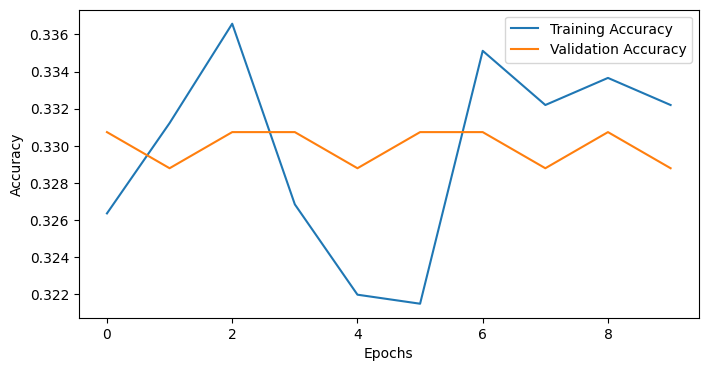

Model saved as 'flac_cnn_classifier.h5'


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from scipy.signal import spectrogram
import soundfile as sf
import matplotlib.pyplot as plt

# --- Step 1: Define a Custom Data Generator ---
class AudioDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, num_classes, input_size=(128, 128)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.input_size = input_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files, batch_labels)
        return X, y

    def __data_generation(self, batch_files, batch_labels):
        X = np.zeros((len(batch_files), *self.input_size, 1), dtype=np.float32)
        y = np.zeros((len(batch_labels), self.num_classes), dtype=np.float32)

        for i, file_path in enumerate(batch_files):
            # Load audio and generate spectrogram
            data, sample_rate = sf.read(file_path)
            if len(data.shape) > 1:
                data = np.mean(data, axis=1)  # Convert to mono
            frequencies, times, Sxx = spectrogram(data, fs=sample_rate)

            # Resize spectrogram to input size
            spectrogram_image = np.log1p(Sxx)
            spectrogram_image = np.resize(spectrogram_image, self.input_size)
            X[i, :, :, 0] = spectrogram_image  # Add channel dimension

            # One-hot encode labels
            y[i, batch_labels[i]] = 1.0

        return X, y

# --- Step 2: Load Data and Labels ---
data_folder = "./audio_data"
labels = {"engine": 0, "speech": 1, "music": 2}

file_paths = []
file_labels = []
for class_name, label in labels.items():
    class_folder = os.path.join(data_folder, class_name)
    for file in os.listdir(class_folder):
        if file.endswith(".flac"):
            file_paths.append(os.path.join(class_folder, file))
            file_labels.append(label)

# Shuffle data
data = list(zip(file_paths, file_labels))
np.random.shuffle(data)
file_paths, file_labels = zip(*data)

# Split into train and validation sets
split_index = int(len(file_paths) * 0.8)
train_files, val_files = file_paths[:split_index], file_paths[split_index:]
train_labels, val_labels = file_labels[:split_index], file_labels[split_index:]

# --- Step 3: Initialize Data Generators ---
batch_size = 16
input_size = (128, 128)
num_classes = len(labels)

train_generator = AudioDataGenerator(train_files, train_labels, batch_size, num_classes, input_size)
val_generator = AudioDataGenerator(val_files, val_labels, batch_size, num_classes, input_size)

# --- Step 4: Build the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*input_size, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Step 5: Train the Model ---
epochs = 10
history = model.fit(train_generator, validation_data=val_generator, epochs=epochs)

# --- Step 6: Plot Training History ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Optional: Save the Model ---
model.save("flac_cnn_classifier.h5")
print("Model saved as 'flac_cnn_classifier.h5'")

### Závěry
- Nedochází k žádnému učení, acurracy odpovídá náhodnému výběru

## Základní model


### Popis modelu

- Kod je upraven pro rychlé zpracování na GPU
  - Data dostává v předzpracováné podobě a nahrává si je do paměti (vyčítání dat ze souboru je největším bottleneckem)
  - Využívá mixed_float16 pro rycheljší výpočty
  - Využívá JIT

- Oproti předchozímu modelu se změnil i způsob předzpracování dat a tvorby spectogramu
  - všechny zvuky byly zkráceny na stejnou délku resamplovány na stejnou frekvency 44100Hz a normalizovány na interval [0,1]
  - Vstupní data jsou ve formě Melova spectogramu resizováného na 128x128x1
    - Melův spectogram je typ spectogramu, který zohledňuje rozsah lidského ucha a upřednostňuje nižší frekvence před vysokými

Loading data from: ./data/chunk_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,287,491 (16.36 MB)

 Trainable params: 4,287,491 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4676 - loss: 1.0203 - val_accuracy: 0.5527 - val_loss: 0.9470 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5851 - loss: 0.8948 - val_accuracy: 0.5762 - val_loss: 0.9220 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5931 - loss: 0.8818 - val_accuracy: 0.5977 - val_loss: 0.9055 - learning_rate: 1.0000e-04
Epoch 4/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6285 - loss: 0.8192 - val_accuracy: 0.6172 - val_loss: 0.8872 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6550 - loss: 0.7851 - val_accuracy: 0.5977 - val_loss: 0.8883 - learning_rate: 1.0000e-04
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6691 - loss: 0.7482 - val_accuracy: 0.5977 - val_loss: 0.8735 - learning_rate: 1.0000e-04
Epoch 7/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6930 - loss: 0.7

Model saved as 'cnn_single_h5_model_wandb.h5'


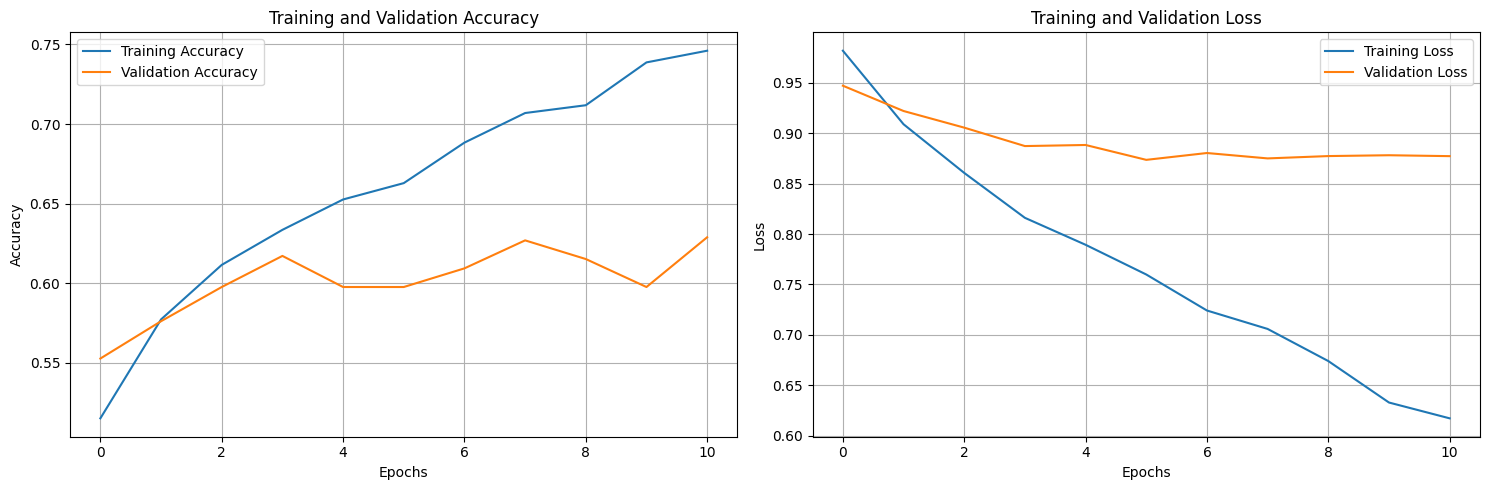

In [ ]:
# Install necessary libraries silently
!pip install --upgrade tensorflow keras wandb --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple_model", settings=wandb.Settings(silent=True), mode="offline")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/chunk_0.h5"

# Set parameters
BATCH_SIZE = 32
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),

    layers.Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]#, wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()


### Zhodnocení
- Model se během první epochy naučí acurracy cca 60% a více už negeneralizuje
- Rostoucí training acurracy naznačuje overfitting
  - Model je příliš složitý na takto malé množství dat (3000 vzorku na 4 000 000 parametrů, podle běžných doporučení by na takto velký model mělo být alespoň 40 000 vzorků)

## Zjednodušení modelu - snížení počtu parametrů


### Popis
- Cílem bylo snížit množství parametrů modelu a tím zabránit overfittingu
- Nahradil jsem Flatten za GlobalAveragePollong2D čímž dojde k rapidnímu snížení počtu parametrl
- Aby model nepřišel o schopnost se učit, přidal jsem další konvoluční vrstvu

Loading data from: ./data/chunk_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 571,651 (2.18 MB)

 Trainable params: 570,179 (2.18 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 122ms/step - accuracy: 0.5396 - loss: 1.2345 - val_accuracy: 0.3359 - val_loss: 1.2722 - learning_rate: 1.0000e-04
Epoch 2/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.6582 - loss: 0.9426 - val_accuracy: 0.3379 - val_loss: 1.3674 - learning_rate: 1.0000e-04
Epoch 3/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7340 - loss: 0.8379 - val_accuracy: 0.3379 - val_loss: 2.8785 - learning_rate: 1.0000e-04
Epoch 4/30
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7440 - loss: 0.7908
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7444 - loss: 0.7909 - val_accuracy: 0.3379 - val_loss: 3.4242 - learning_rate: 1.0000e-04
Epoch 5/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7665 - loss: 0.7457 - val_accuracy: 0.3379 - val_loss: 4.5775 - learning_rate: 5.0000e-05
Epoch 6/30
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7945 - loss: 0.6916

Model saved as 'cnn_single_h5_model_wandb.h5'


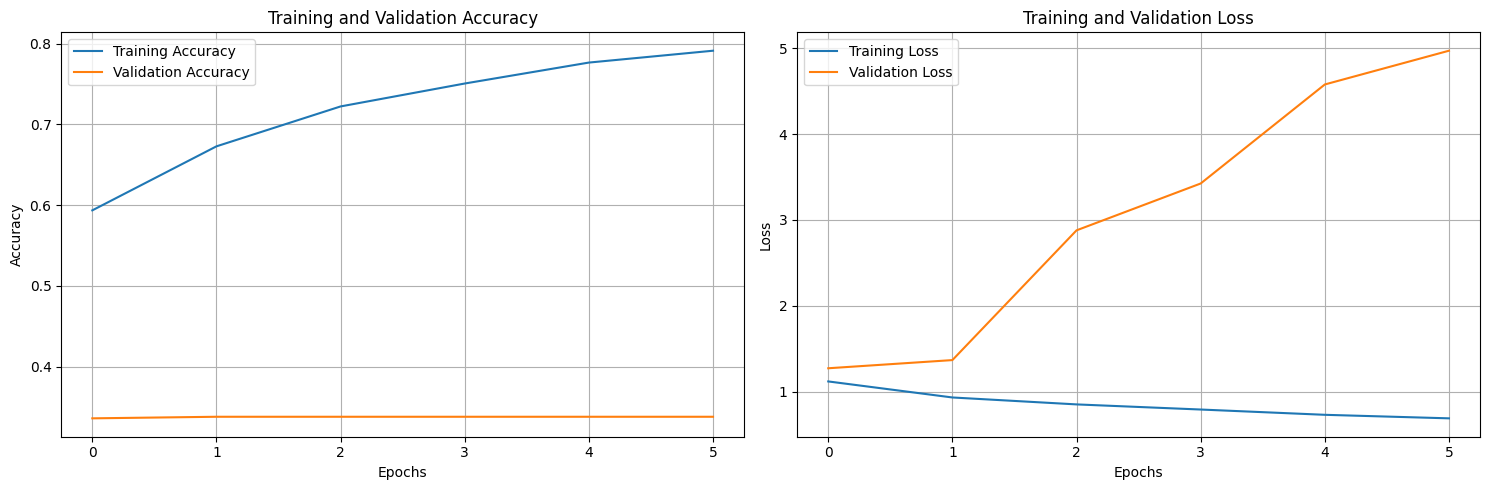

In [ ]:
# Install necessary libraries silently
import os
os.system("pip install --upgrade tensorflow keras wandb --quiet")

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple__less_params__dropout", settings=wandb.Settings(silent=True))

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/chunk_0.h5"

# Set parameters
BATCH_SIZE = 32
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    # Block 4 (optional, to add capacity)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),  # Reduces parameters

    # Dense Layer
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
])


optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]# , wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History ---
# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()

### Vyhodnocení
- Tento přístup nevede k cíli, model přišel o schopnost generalizovat a k overfitingu stále dochází
- data jsou nejspíše příliš složitá, bez flatten vrstvy nemá model dostatečnou kapacitu k jejich pochopení

## Zmenšení vrstev a přidání dropoutu


### Popis
- Flatten zůstane v modelu, pouze zmenšíme množství konvolučních filtrů a vrstev u Dense
- Zapojíme dropout

Loading data from: ./data/chunk_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_70 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_71 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_72 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_65 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_60               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,288,899 (16.36 MB)

 Trainable params: 4,288,195 (16.36 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


511/511 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.4364 - loss: 1.4395 - val_accuracy: 0.3984 - val_loss: 4.0677 - learning_rate: 1.0000e-04
Epoch 2/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5103 - loss: 1.2254 - val_accuracy: 0.5508 - val_loss: 1.3278 - learning_rate: 1.0000e-04
Epoch 3/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5283 - loss: 1.1555 - val_accuracy: 0.5273 - val_loss: 1.6268 - learning_rate: 1.0000e-04
Epoch 4/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5541 - loss: 1.0591 - val_accuracy: 0.5801 - val_loss: 1.4746 - learning_rate: 1.0000e-04
Epoch 5/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5744 - loss: 1.0233 - val_accuracy: 0.5879 - val_loss: 1.1123 - learning_rate: 1.0000e-04
Epoch 6/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5941 - loss: 0.9654 - val_accuracy: 0.5723 - val_loss: 1.8255 - learning_rate: 1.0000e-04
Epoch 7/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6165 - 

Model saved as 'cnn_single_h5_model_wandb.h5'


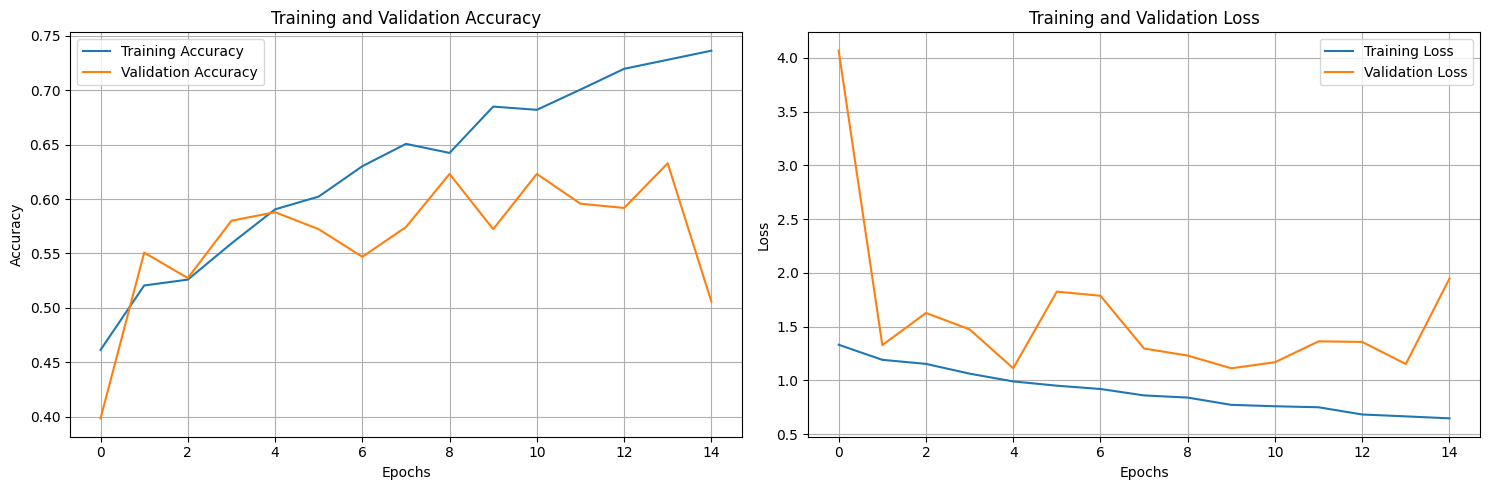

In [ ]:
# Install necessary libraries silently
!pip install --upgrade tensorflow keras wandb --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple_model", settings=wandb.Settings(silent=True), mode="offline")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/chunk_0.h5"

# Set parameters
BATCH_SIZE = 4
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
from tensorflow.keras import models, layers, regularizers


model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Dense Layers
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])



optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]#, wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()


### Zhodnocení
- Vyzkoušeno mnoho různých dropoutů, nastavení learning rate i batch_size
- Největší vliv na schopnost učení má **batch size**, dropout zpomalil overfitting
- Model možná stále není dost velký, aby byl schopný obsáhnout komplexitu dat, zkusím přidat další konvoluční vrstvu

## Složitější model - 4 konvoluční bloky

## Popis
- Přidáme další konvoluční vrstvu, díky níž by model mohl být schopen sledovat větší detaily
- Další konvoluční vrstva by mohla zlepšit schopnost rozpoznávat menší detaily

Loading data from: ./data/chunk_0.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,586,115 (17.49 MB)

 Trainable params: 4,584,643 (17.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


511/511 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.4275 - loss: 1.5676 - val_accuracy: 0.3379 - val_loss: 3.8605 - learning_rate: 1.0000e-04
Epoch 2/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5164 - loss: 1.2878 - val_accuracy: 0.4824 - val_loss: 1.6763 - learning_rate: 1.0000e-04
Epoch 3/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5397 - loss: 1.1592 - val_accuracy: 0.5371 - val_loss: 1.1785 - learning_rate: 1.0000e-04
Epoch 4/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5392 - loss: 1.0963 - val_accuracy: 0.6133 - val_loss: 1.3892 - learning_rate: 1.0000e-04
Epoch 5/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5544 - loss: 1.0967 - val_accuracy: 0.5059 - val_loss: 1.4713 - learning_rate: 1.0000e-04
Epoch 6/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5839 - loss: 1.0733 - val_accuracy: 0.5332 - val_loss: 1.7607 - learning_rate: 1.0000e-04
Epoch 7/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5702 - 

Model saved as 'cnn_single_h5_model_wandb.h5'


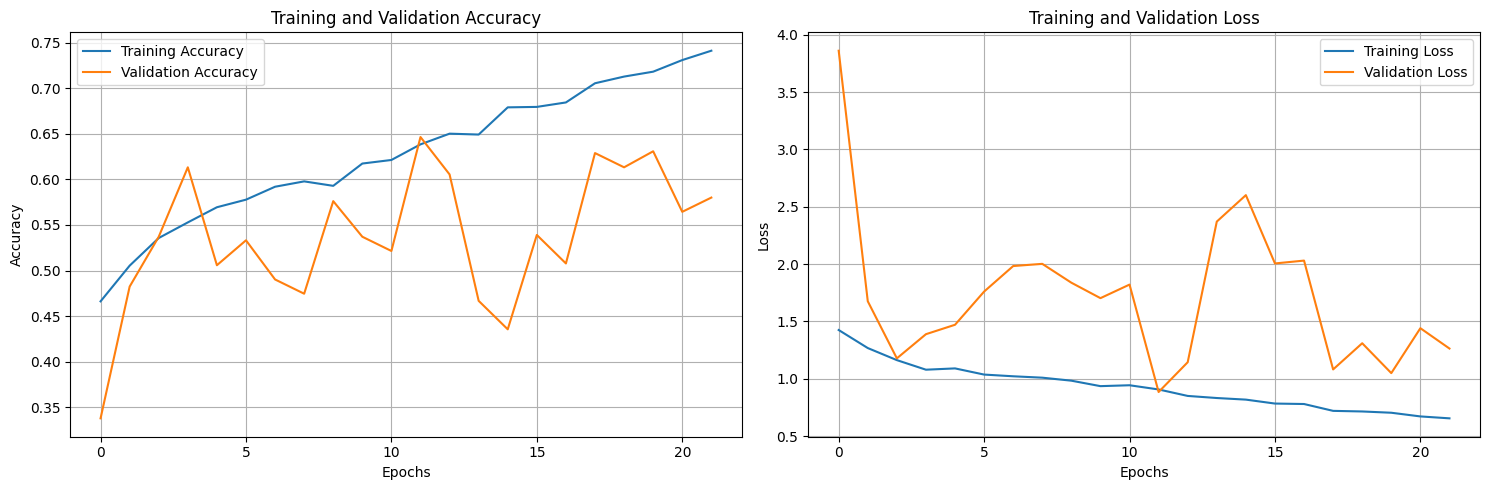

In [ ]:
# Install necessary libraries silently
!pip install --upgrade tensorflow keras wandb --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple_model", settings=wandb.Settings(silent=True), mode="offline")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/chunk_0.h5"

# Set parameters
BATCH_SIZE = 4
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
from tensorflow.keras import models, layers, regularizers


model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Adjust dropout slightly

    # Block 4 (New Block)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Slightly higher dropout

    # Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Keep dropout for regularization

    layers.Dense(num_classes, activation='softmax')
])



optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]#, wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()


## Závěry
- Nezdá se, že by další konvoluční vrstva přinesla lepší výsledky

- Vyzkoušena i větší Dense vrstva se stejnými výsledky

# Rozlišení dat na 256x256x1
- Zdá se, že v předchozím případě jsme již vyčerpali možnosti jak zlepšit výsledky, Loss funkce už dále nekonverguje a přesnost se zastaví na cca 66%
- Větší spektogramy znamenají detailnější informace a mohli by umožnit lépe rozlišovat jednotlivé třídy


## Validace dat
Ověření, že data z hlediska formátu obsahují vše co mají a po vizuální stránkce vypadají "normálně"

### Zobrazení formátu dat
- slouží k ověření, že data jsou ve správném formátu a obsahují labely

In [ ]:
import h5py

# Path to your HDF5 file
file_path = "./data/data_256.h5"

# Function to list datasets and attributes
def inspect_hdf5_file(file_path):
    """List all datasets and attributes in an HDF5 file."""
    with h5py.File(file_path, "r") as hf:
        print("\n--- HDF5 File Structure ---")
        def print_hierarchy(name, obj):
            if isinstance(obj, h5py.Dataset):
                print(f"Dataset: {name} | Shape: {obj.shape} | Dtype: {obj.dtype}")
            elif isinstance(obj, h5py.Group):
                print(f"Group: {name}")

        # Print all groups and datasets
        hf.visititems(print_hierarchy)

        # Print attributes
        print("\n--- File Attributes ---")
        for attr in hf.attrs:
            print(f"{attr}: {hf.attrs[attr]}")

# Inspect the file
inspect_hdf5_file(file_path)


--- HDF5 File Structure ---
Dataset: labels | Shape: (2556,) | Dtype: int32
Dataset: spectrograms | Shape: (2556, 256, 256) | Dtype: float32

--- File Attributes ---
class_mapping: {'engine': 0, 'speech': 1, 'music': 2}


### Validace hodnot
- Vizuální kontrola, že hodnoty v datasetu se pohybují v rozumných mezích.

In [ ]:
import numpy as np
import h5py

def calculate_statistics_from_h5_file(h5_file_path):
    """
    Calculate overall statistics (min, max, median, average) for all spectrograms in an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.

    Returns:
        dict: Overall statistics including min, max, median, and average.
    """
    overall_min = float('inf')
    overall_max = float('-inf')
    all_medians = []
    total_sum = 0.0
    total_count = 0

    print(f"Processing: {h5_file_path}")
    try:
        with h5py.File(h5_file_path, "r") as hf:
            # Load spectrogram data
            spectrograms = hf["spectrograms"][:]  # Load all spectrograms at once

            # Update statistics
            overall_min = np.min(spectrograms)
            overall_max = np.max(spectrograms)
            all_medians.append(np.median(spectrograms))
            total_sum = np.sum(spectrograms)
            total_count = spectrograms.size

    except Exception as e:
        print(f"Error processing {h5_file_path}: {e}")
        return None

    # Compute overall statistics
    overall_average = total_sum / total_count
    overall_median = np.median(all_medians)

    # Combine results into a dictionary
    statistics = {
        "Overall Min": overall_min,
        "Overall Max": overall_max,
        "Overall Median": overall_median,
        "Overall Average": overall_average,
    }

    return statistics


if __name__ == "__main__":
    # Path to the HDF5 file
    h5_file_path = "./data/data_256.h5"  # Replace with your HDF5 file path

    # Calculate overall statistics
    stats = calculate_statistics_from_h5_file(h5_file_path)

    # Print the results
    if stats:
        print("\n--- Overall Statistics for Spectrograms in HDF5 File ---")
        for key, value in stats.items():
            print(f"{key}: {value}")


Processing: ./data/data_256.h5

--- Overall Statistics for Spectrograms in HDF5 File ---
Overall Min: -0.15846335887908936
Overall Max: 1.2324082851409912
Overall Median: 0.005836649797856808
Overall Average: 0.07078447177749658


### Zobrazení spectogramů
- slouží pro vizuální kontrolu, že spectogramy vypadají rozumně

Total spectrograms in file: 2556


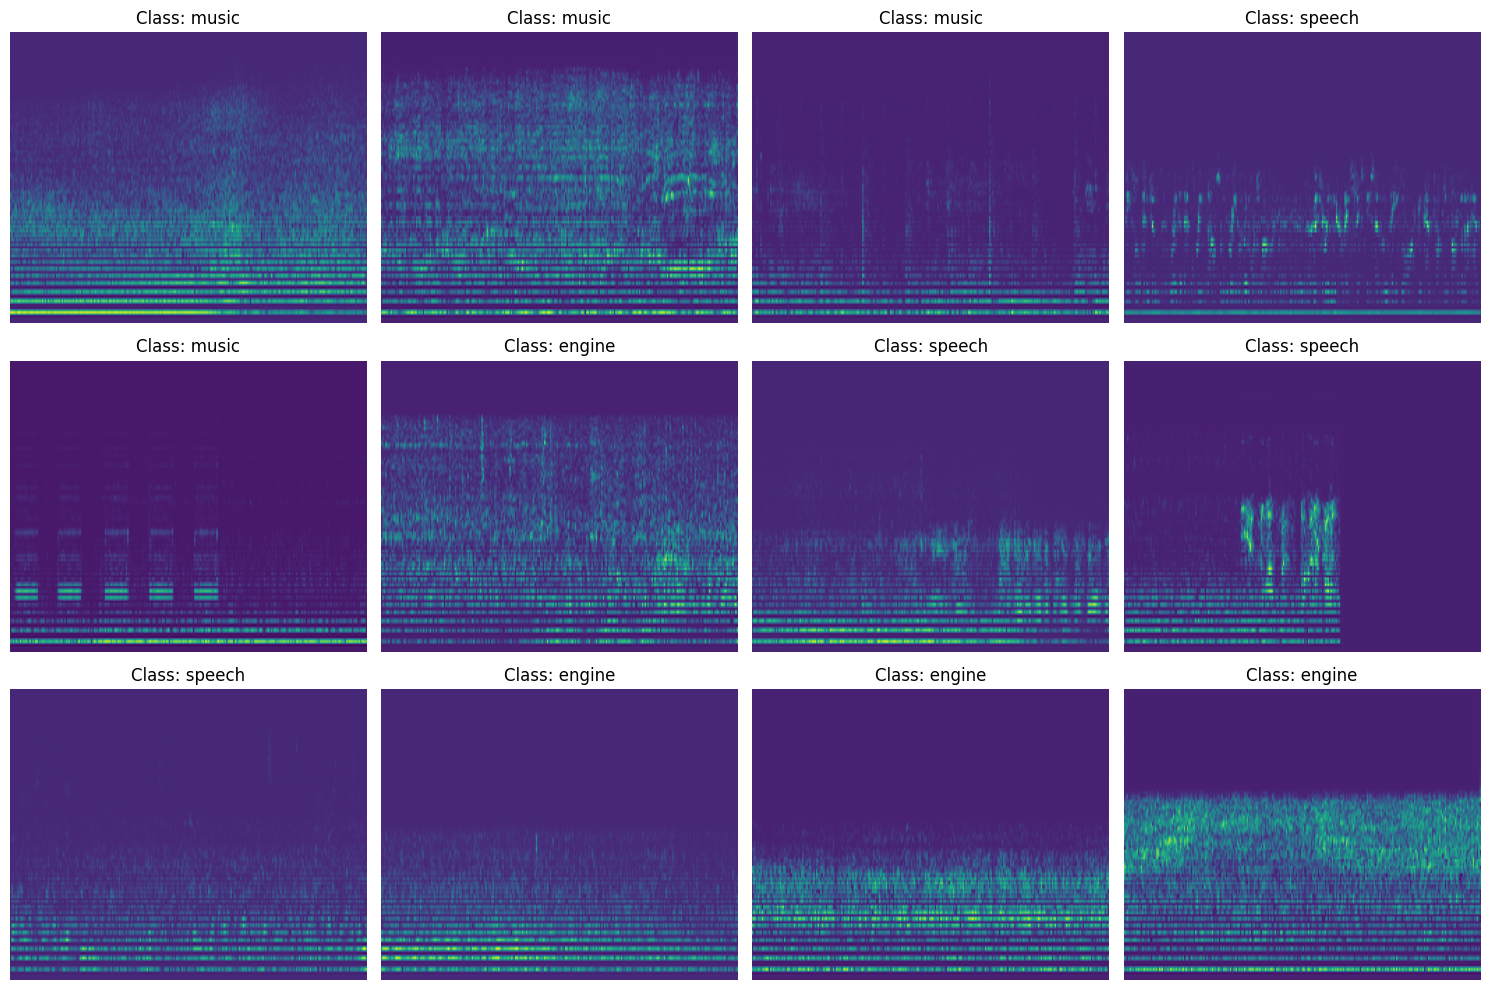

In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random

def load_random_spectrograms(h5_file_path, num_samples=12):
    """
    Load a specified number of random spectrograms from an HDF5 file.

    Parameters:
        h5_file_path (str): Path to the HDF5 file.
        num_samples (int): Number of random spectrograms to load.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Random spectrograms and their corresponding labels.
    """
    with h5py.File(h5_file_path, "r") as hf:
        spectrograms = hf["spectrograms"][:]
        labels = hf["labels"][:]
        print(f"Total spectrograms in file: {spectrograms.shape[0]}")

        # Ensure we don't exceed the number of available samples
        num_samples = min(num_samples, spectrograms.shape[0])

        # Randomly select indices
        indices = random.sample(range(spectrograms.shape[0]), num_samples)
        random_spectrograms = spectrograms[indices]
        random_labels = labels[indices]

    return random_spectrograms, random_labels

def plot_spectrograms(spectrograms, labels, grid_shape=(3, 4), class_mapping=None):
    """
    Plot spectrograms in a grid.

    Parameters:
        spectrograms (np.ndarray): Spectrogram data to plot.
        labels (np.ndarray): Corresponding labels.
        grid_shape (tuple): Shape of the grid (rows, cols).
        class_mapping (dict): Mapping of class indices to class names (optional).
    """
    rows, cols = grid_shape
    plt.figure(figsize=(15, 10))

    for i, (spec, label) in enumerate(zip(spectrograms, labels)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(spec, aspect="auto", origin="lower", cmap="viridis")
        title = f"Class: {label}" if class_mapping is None else f"Class: {class_mapping[label]}"
        plt.title(title)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# --- Example Usage ---
if __name__ == "__main__":
    # Path to HDF5 file
    h5_file_path = "./data/data_256.h5"  # Replace with your HDF5 file path

    # Class mapping for display (optional)
    class_mapping = {0: "engine", 1: "speech", 2: "music"}

    # Load 12 random spectrograms
    spectrograms, labels = load_random_spectrograms(h5_file_path, num_samples=12)

    # Plot the spectrograms
    plot_spectrograms(spectrograms, labels, grid_shape=(3, 4), class_mapping=class_mapping)

## Model se 4 konvolučními vrstvami na 256x256

Loading data from: ./data/data_256.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 17,169,027 (65.49 MB)

 Trainable params: 17,167,555 (65.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


511/511 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 0.4424 - loss: 1.4554 - val_accuracy: 0.3086 - val_loss: 9.6254 - learning_rate: 1.0000e-04
Epoch 2/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5005 - loss: 1.2234 - val_accuracy: 0.4785 - val_loss: 2.9595 - learning_rate: 1.0000e-04
Epoch 3/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5419 - loss: 1.1491 - val_accuracy: 0.4668 - val_loss: 4.1458 - learning_rate: 1.0000e-04
Epoch 4/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6054 - loss: 1.0163 - val_accuracy: 0.5684 - val_loss: 2.7133 - learning_rate: 1.0000e-04
Epoch 5/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6018 - loss: 0.9814 - val_accuracy: 0.4902 - val_loss: 2.7439 - learning_rate: 1.0000e-04
Epoch 6/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6174 - loss: 0.9362 - val_accuracy: 0.5605 - val_loss: 2.0317 - learning_rate: 1.0000e-04
Epoch 7/30
511/511 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.

Model saved as 'cnn_single_h5_model_wandb.h5'


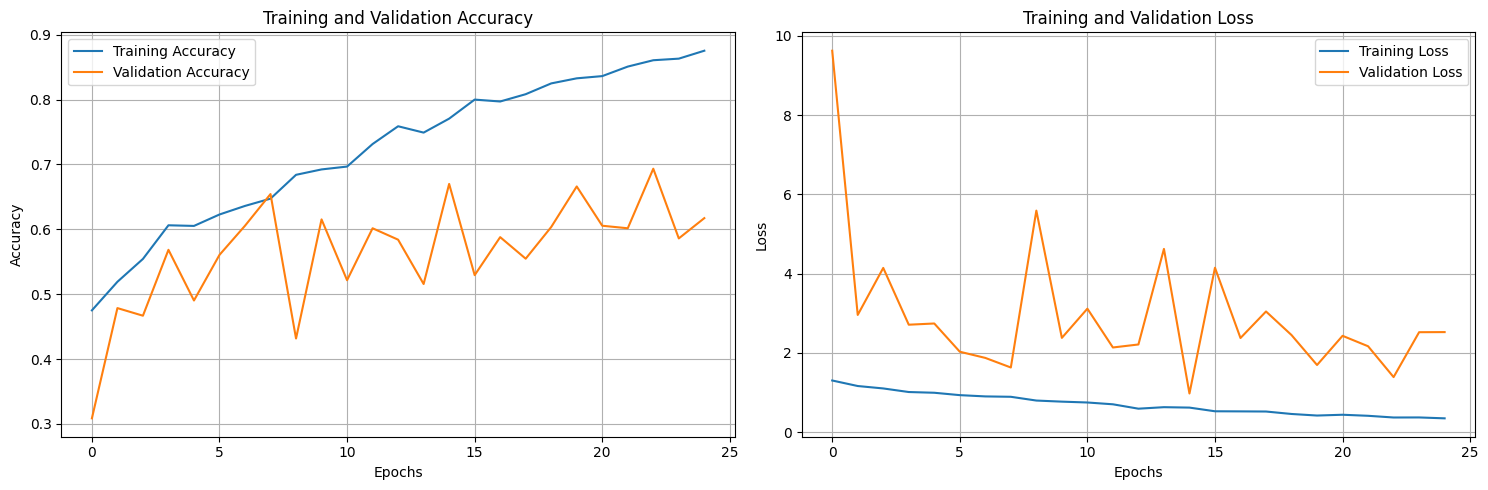

In [ ]:
# Install necessary libraries silently
!pip install --upgrade tensorflow keras wandb --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple_model", settings=wandb.Settings(silent=True), mode="offline")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/data_256.h5"

# Set parameters
BATCH_SIZE = 4
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
from tensorflow.keras import models, layers, regularizers


model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Adjust dropout slightly

    # Block 4 (New Block)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Slightly higher dropout

    # Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Keep dropout for regularization

    layers.Dense(num_classes, activation='softmax')
])



optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]#, wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()


## Závěr
- Zdá se že model 256x256 performuje o trochu lépe, obecně se ale nedaří dostat stabilně accuracy nad 70%
- Důvody mohou být
  - Velké množství špatně označených dat
  - Neschopnost modelu přizpůsobit se šumu
  - Příliš malý dataset

- Cestou tedy může být zvýšení velikosti datasetu pomocí preprocessingu


# Další pokusy o zlepšení (po dueDate)

## Popis
Snaha o zlepšení výsledků pomocí lepšího preprocessingu
- Množství dat pro zpracování lze zlepšit pomoc
- Rozsekání zvukové stopy na menší části a vypočátání histogramů nad ní
- 128x128

## Model
- 4 konvoluční vrstvy + dropout

### Příprava dat
- Vzhledem k omezenému upload size na colabu jsou data uložena v podobě chunků
- Následující skript je zkombinuje do jednoho výsledného souboru

In [ ]:
import os
import h5py
import numpy as np

def combine_h5_files(input_folder, output_folder, output_filename="combined_output.h5"):
    """
    Combine all HDF5 chunk files from the input folder into a single HDF5 file in the output folder.

    Parameters:
        input_folder (str): Path to the folder containing HDF5 chunk files.
        output_folder (str): Path to the folder where the combined HDF5 file will be saved.
        output_filename (str): Name of the combined HDF5 file.
    """
    # Initialize lists to collect data and labels
    combined_spectrograms = []
    combined_labels = []
    class_mapping = None

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Find all HDF5 files in the input folder
    input_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.h5')])

    if not input_files:
        print(f"No HDF5 files found in '{input_folder}'. Exiting...")
        return

    print(f"Found {len(input_files)} HDF5 files in '{input_folder}'. Combining...")

    # Iterate through the HDF5 files and combine data
    for file_path in input_files:
        print(f"Reading file: {file_path}")
        try:
            with h5py.File(file_path, 'r') as hf:
                # Read spectrograms and labels
                spectrograms = np.array(hf['spectrograms'])
                labels = np.array(hf['labels'])
                combined_spectrograms.append(spectrograms)
                combined_labels.append(labels)

                # Read class mapping (ensure it's consistent)
                if class_mapping is None:
                    class_mapping = eval(hf.attrs['class_mapping'])
                elif class_mapping != eval(hf.attrs['class_mapping']):
                    raise ValueError("Class mapping mismatch between HDF5 files!")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # Concatenate all data and labels
    combined_spectrograms = np.concatenate(combined_spectrograms, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    # Save combined data into a single HDF5 file
    output_file = os.path.join(output_folder, output_filename)
    with h5py.File(output_file, 'w') as hf_out:
        hf_out.create_dataset('spectrograms', data=combined_spectrograms, dtype='float32')
        hf_out.create_dataset('labels', data=combined_labels, dtype='int32')
        hf_out.attrs['class_mapping'] = str(class_mapping)

    print(f"Combined HDF5 file saved to: {output_file}")
    print(f"Total samples: {combined_spectrograms.shape[0]}")

if __name__ == "__main__":
    # Define input and output folders
    input_folder = "./data_chunked"  # Folder containing chunked HDF5 files
    output_folder = "./data"  # Folder to save the combined HDF5 file

    # Run the combine function
    combine_h5_files(input_folder, output_folder)

Found 2 HDF5 files in './data_chunked'. Combining...
Reading file: ./data_chunked/chunk_0.h5
Reading file: ./data_chunked/chunk_1.h5
Combined HDF5 file saved to: ./data/combined_output.h5
Total samples: 22726


### Učení

Loading data from: ./data/combined_output.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,586,115 (17.49 MB)

 Trainable params: 4,584,643 (17.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - accuracy: 0.4785 - loss: 1.3025 - val_accuracy: 0.6351 - val_loss: 1.1265 - learning_rate: 1.0000e-04
Epoch 2/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.5907 - loss: 0.9793 - val_accuracy: 0.6423 - val_loss: 1.1155 - learning_rate: 1.0000e-04
Epoch 3/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.6198 - loss: 0.9105 - val_accuracy: 0.6764 - val_loss: 0.8818 - learning_rate: 1.0000e-04
Epoch 4/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.6443 - loss: 0.8462 - val_accuracy: 0.5603 - val_loss: 1.6634 - learning_rate: 1.0000e-04
Epoch 5/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.6625 - loss: 0.8088 - val_accuracy: 0.6760 - val_loss: 0.8632 - learning_rate: 1.0000e-04
Epoch 6/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 41s 6ms/step - accuracy: 0.6719 - loss: 0.8010 - val_accuracy: 0.7191 - val_loss: 0.7501 - learning_rate: 1.0000e-04
Epoch 7/30
4545/4545 ━━━━━━━━━━━━━━━━━━━━ 31s 

Model saved as 'cnn_single_h5_model_wandb.h5'


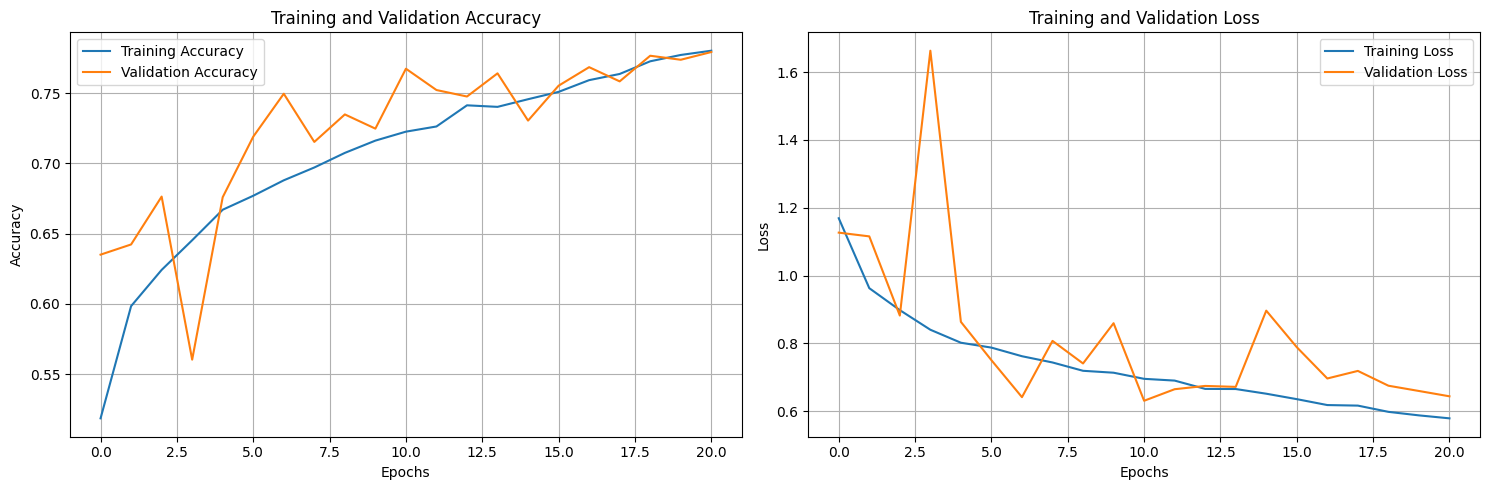

In [ ]:
# Install necessary libraries silently
!pip install --upgrade tensorflow keras wandb --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple_model", settings=wandb.Settings(silent=True), mode="offline")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/combined_output.h5"

# Set parameters
BATCH_SIZE = 4
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
from tensorflow.keras import models, layers, regularizers


model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Adjust dropout slightly

    # Block 4 (New Block)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Slightly higher dropout

    # Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Keep dropout for regularization

    layers.Dense(num_classes, activation='softmax')
])



optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]#, wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()

## Závěry
- Zvýšeni počtu vstupním souborů pomocí preprocessingu (rozdělení na menší části + overlap) vedlo k výrazné stabilizaci učení
- Největší překážkou je teď tedy primárně špatné labelování dat (vstupní data obsahují mezi 5-10% špatných labelů)

# Další pokusy o zlepšení - preprocessing 256x256 (po dueDate)

## Popis
Snaha o zlepšení výsledků pomocí lepšího preprocessingu
- Množství dat pro zpracování lze zlepšit pomoc
- Rozsekání zvukové stopy na menší části a vypočátání histogramů nad ní
- 256x256

## Model
- 4 konvoluční vrstvy + dropout

### Příprava dat
- Vzhledem k omezenému upload size na colabu jsou data uložena v podobě chunků
- Následující skript je zkombinuje do jednoho výsledného souboru

In [ ]:
import os
import h5py
import numpy as np

def combine_h5_files(input_folder, output_folder, output_filename="combined_output_256.h5"):
    """
    Combine all HDF5 chunk files from the input folder into a single HDF5 file in the output folder.

    Parameters:
        input_folder (str): Path to the folder containing HDF5 chunk files.
        output_folder (str): Path to the folder where the combined HDF5 file will be saved.
        output_filename (str): Name of the combined HDF5 file.
    """
    # Initialize lists to collect data and labels
    combined_spectrograms = []
    combined_labels = []
    class_mapping = None

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Find all HDF5 files in the input folder
    input_files = sorted([os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith('.h5')])

    if not input_files:
        print(f"No HDF5 files found in '{input_folder}'. Exiting...")
        return

    print(f"Found {len(input_files)} HDF5 files in '{input_folder}'. Combining...")

    # Iterate through the HDF5 files and combine data
    for file_path in input_files:
        print(f"Reading file: {file_path}")
        try:
            with h5py.File(file_path, 'r') as hf:
                # Read spectrograms and labels
                spectrograms = np.array(hf['spectrograms'])
                labels = np.array(hf['labels'])
                combined_spectrograms.append(spectrograms)
                combined_labels.append(labels)

                # Read class mapping (ensure it's consistent)
                if class_mapping is None:
                    class_mapping = eval(hf.attrs['class_mapping'])
                elif class_mapping != eval(hf.attrs['class_mapping']):
                    raise ValueError("Class mapping mismatch between HDF5 files!")
        except Exception as e:
            print(f"Error reading {file_path}: {e}")

    # Concatenate all data and labels
    combined_spectrograms = np.concatenate(combined_spectrograms, axis=0)
    combined_labels = np.concatenate(combined_labels, axis=0)

    # Save combined data into a single HDF5 file
    output_file = os.path.join(output_folder, output_filename)
    with h5py.File(output_file, 'w') as hf_out:
        hf_out.create_dataset('spectrograms', data=combined_spectrograms, dtype='float32')
        hf_out.create_dataset('labels', data=combined_labels, dtype='int32')
        hf_out.attrs['class_mapping'] = str(class_mapping)

    print(f"Combined HDF5 file saved to: {output_file}")
    print(f"Total samples: {combined_spectrograms.shape[0]}")

if __name__ == "__main__":
    # Define input and output folders
    input_folder = "./data_chunked_256"  # Folder containing chunked HDF5 files
    output_folder = "./data"  # Folder to save the combined HDF5 file

    # Run the combine function
    combine_h5_files(input_folder, output_folder)

Found 5 HDF5 files in './data_chunked_256'. Combining...
Reading file: ./data_chunked_256/chunk_0.h5
Reading file: ./data_chunked_256/chunk_1.h5
Reading file: ./data_chunked_256/chunk_2.h5
Reading file: ./data_chunked_256/chunk_3.h5
Reading file: ./data_chunked_256/chunk_4.h5
Combined HDF5 file saved to: ./data/combined_output_256.h5
Total samples: 22413


### Učení

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 100.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
Loading data from: ./data/combined_output_256.h5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      16,777,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 17,169,027 (65.49 MB)

 Trainable params: 17,167,555 (65.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4483/4483 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - accuracy: 0.5016 - loss: 1.2573 - val_accuracy: 0.5329 - val_loss: 1.3397 - learning_rate: 1.0000e-04
Epoch 2/30
4483/4483 ━━━━━━━━━━━━━━━━━━━━ 47s 11ms/step - accuracy: 0.6039 - loss: 0.9811 - val_accuracy: 0.4876 - val_loss: 4.1881 - learning_rate: 1.0000e-04
Epoch 3/30
4483/4483 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.6395 - loss: 0.8776 - val_accuracy: 0.7024 - val_loss: 0.9342 - learning_rate: 1.0000e-04
Epoch 4/30
4483/4483 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.6693 - loss: 0.8110 - val_accuracy: 0.6583 - val_loss: 1.0070 - learning_rate: 1.0000e-04
Epoch 5/30
4483/4483 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.6848 - loss: 0.7561 - val_accuracy: 0.6924 - val_loss: 1.0109 - learning_rate: 1.0000e-04
Epoch 6/30
4483/4483 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/step - accuracy: 0.7048 - loss: 0.7314 - val_accuracy: 0.7457 - val_loss: 0.7093 - learning_rate: 1.0000e-04
Epoch 7/30
4483/4483 ━━━━━━━━━━━━━━━━━━━━ 48s 11ms/

Model saved as 'cnn_single_h5_model_wandb.h5'


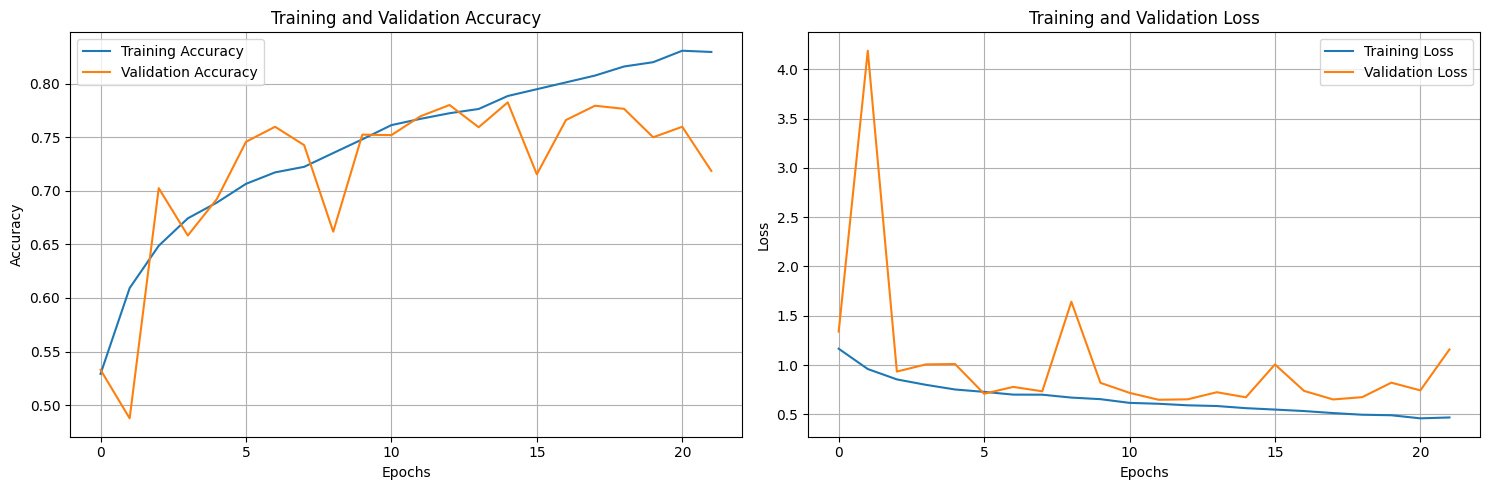

In [ ]:
# Install necessary libraries silently
!pip install --upgrade tensorflow keras wandb --quiet

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import h5py
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

# --- Initialize Wandb ---
# wandb.init(project="su2_noise_classification", name="simple_model", settings=wandb.Settings(silent=True), mode="offline")

# --- Enable Mixed Precision and XLA Compilation ---
tf.keras.mixed_precision.set_global_policy("mixed_float16")
tf.config.optimizer.set_jit(True)

# --- Step 1: Load HDF5 Data into Memory ---
def load_single_h5_to_memory(h5_file, split=0.8):
    print(f"Loading data from: {h5_file}")
    with h5py.File(h5_file, "r") as hf:
        spectrograms = np.array(hf["spectrograms"], dtype=np.float32)
        labels = np.array(hf["labels"], dtype=np.int32)

    spectrograms = spectrograms[..., np.newaxis]  # Add channel dimension
    num_classes = len(np.unique(labels))
    labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

    X_train, X_val, y_train, y_val = train_test_split(
        spectrograms, labels, test_size=1-split, random_state=42, stratify=labels
    )
    return (X_train, y_train), (X_val, y_val), num_classes

# --- Step 2: Define In-Memory Data Generator ---
class InMemoryDataGenerator(Sequence):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.indices = np.arange(len(self.X))
        np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

# --- Step 3: Load Data ---
h5_file = "./data/combined_output_256.h5"

# Set parameters
BATCH_SIZE = 4
EPOCHS = 30

(X_train, y_train), (X_val, y_val), num_classes = load_single_h5_to_memory(h5_file)

# Initialize In-Memory Data Generators
train_generator = InMemoryDataGenerator(X_train, y_train, BATCH_SIZE)
val_generator = InMemoryDataGenerator(X_val, y_val, BATCH_SIZE)

# --- Step 4: Define the CNN Model ---
from tensorflow.keras import models, layers, regularizers


model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),  # Adjust dropout slightly

    # Block 4 (New Block)
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Slightly higher dropout

    # Dense Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),  # Keep dropout for regularization

    layers.Dense(num_classes, activation='softmax')
])



optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 5: Define Callbacks ---
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Correct WandbMetricsLogger integration
# wandb_logger = WandbMetricsLogger(log_freq="epoch")

# --- Step 6: Train the Model ---
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]#, wandb_logger]
)

# --- Step 7: Save the Model ---
model.save("cnn_single_h5_model_wandb.h5")
print("Model saved as 'cnn_single_h5_model_wandb.h5'")

# --- Step 8: Plot Training History Side by Side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()


# --- Finish Wandb Run ---
# wandb.finish()

### Závěry
- Nezdá se, že by velikost spectogramu zásadně ovlivňovala učení, největším problémem bude skutečně špatné labelování datasetu